In [8]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
training=os.path.abspath('train.csv')
testing=os.path.abspath('test.csv')

In [9]:
train= pd.read_csv(training)
test = pd.read_csv(testing)

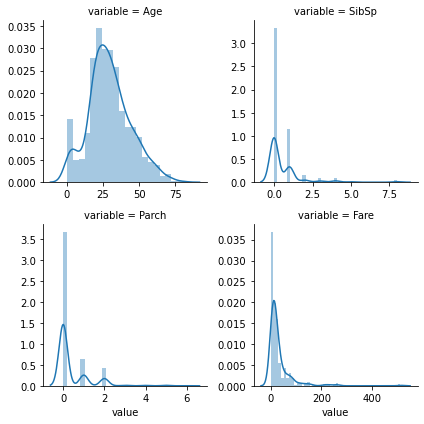

In [10]:
#Put quantitative features in an array
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('Survived')
quantitative.remove('PassengerId')
quantitative.remove('Pclass')

#Put qualitative features in an array
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
qualitative.remove('Name')
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

quantitative_test = [f for f in test.columns if test.dtypes[f] != 'object']

quantitative_test.remove('PassengerId')
quantitative_test.remove('Pclass')
qualitative_test = [f for f in test.columns if test.dtypes[f] == 'object']
qualitative_test.remove('Name')


In [11]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')
        
for c in qualitative_test:
    test[c] = test[c].astype('category')
    if test[c].isnull().any():
        test[c] = test[c].cat.add_categories(['MISSING'])
        test[c] = test[c].fillna('MISSING')      

In [12]:
qualitative.append('Pclass')

qualitative_test.append('Pclass')

In [13]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Age,177,0.198653
Embarked,0,0.000000
Cabin,0,0.000000
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [14]:
#missing data
total_test = test.isnull().sum().sort_values(ascending=False)
percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_test

,Total,Percent
Age,177,0.198653
Embarked,0,0.000000
Cabin,0,0.000000
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


Fill missing data with column average.

In [15]:
my_imputer = SimpleImputer()
train[quantitative] = my_imputer.fit_transform(train[quantitative])

In [16]:
test[quantitative_test] = my_imputer.fit_transform(test[quantitative_test])

In [18]:
train["Name"] = train["Name"].str.split(",").str.get(0)
train.groupby('Name')
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund,male,22.000000,1.0,0.0,A/5 21171,7.2500,MISSING,S
1,2,1,1,Cumings,female,38.000000,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen,female,26.000000,0.0,0.0,STON/O2. 3101282,7.9250,MISSING,S
3,4,1,1,Futrelle,female,35.000000,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,Allen,male,35.000000,0.0,0.0,373450,8.0500,MISSING,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,Montvila,male,27.000000,0.0,0.0,211536,13.0000,MISSING,S
887,888,1,1,Graham,female,19.000000,0.0,0.0,112053,30.0000,B42,S
888,889,0,3,Johnston,female,29.699118,1.0,2.0,W./C. 6607,23.4500,MISSING,S
889,890,1,1,Behr,male,26.000000,0.0,0.0,111369,30.0000,C148,C


In [19]:
test["Name"] = test["Name"].str.split(",").str.get(0)
test.groupby('Name')
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,Kelly,male,34.50000,0.0,0.0,330911,7.8292,MISSING,Q
1,893,3,Wilkes,female,47.00000,1.0,0.0,363272,7.0000,MISSING,S
2,894,2,Myles,male,62.00000,0.0,0.0,240276,9.6875,MISSING,Q
3,895,3,Wirz,male,27.00000,0.0,0.0,315154,8.6625,MISSING,S
4,896,3,Hirvonen,female,22.00000,1.0,1.0,3101298,12.2875,MISSING,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,Spector,male,30.27259,0.0,0.0,A.5. 3236,8.0500,MISSING,S
414,1306,1,Oliva y Ocana,female,39.00000,0.0,0.0,PC 17758,108.9000,C105,C
415,1307,3,Saether,male,38.50000,0.0,0.0,SOTON/O.Q. 3101262,7.2500,MISSING,S
416,1308,3,Ware,male,30.27259,0.0,0.0,359309,8.0500,MISSING,S


In [20]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['Survived'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

Look at correlations.

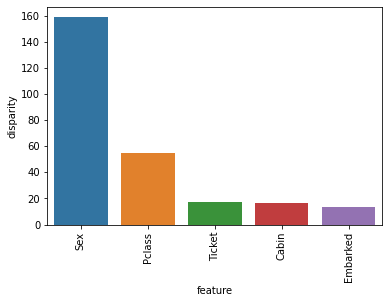

In [22]:
a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

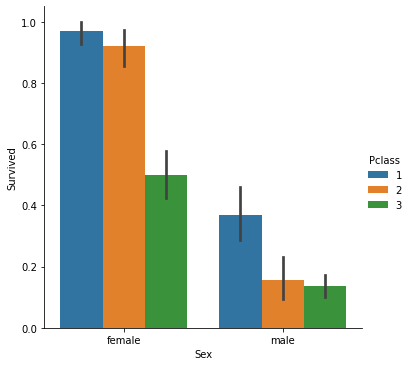

In [23]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=train)

In [24]:
train["Cabin1"] = train["Cabin"].str.get(0)
#train.groupby('Name')

test["Cabin1"] = test["Cabin"].str.get(0)
test.groupby('Name')
train['Cabin1'].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

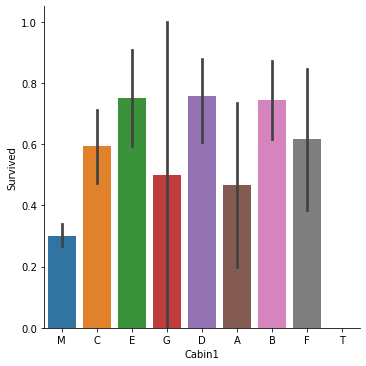

In [25]:
sns.catplot(x="Cabin1", y="Survived", kind="bar", data=train)

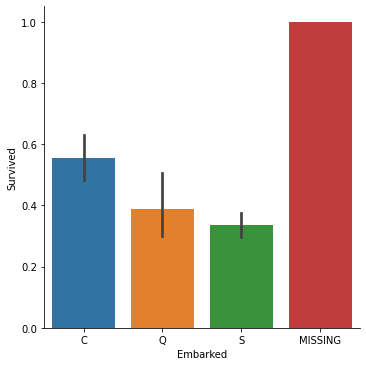

In [26]:
sns.catplot(x="Embarked", y="Survived", kind="bar", data=train)

In [27]:
sex = ['male', 'female']
cabin = ['T','M', 'A', 'G','F','C','E','D','B']
embarked=['S','Q','C','MISSING']

In [28]:
# Now, when you instantiate the encoder, both of these lists go in one big categories list:
encoder = OrdinalEncoder(categories=[sex, cabin,embarked])

In [29]:
my_array=encoder.fit_transform(train[['Sex', 'Cabin1','Embarked']]).reshape((891,3)).tolist()
my_array_test=encoder.fit_transform(test[['Sex', 'Cabin1','Embarked']]).reshape((418,3)).tolist()

In [30]:
train[['Sex','Cabin1','Embarked']]=my_array
test[['Sex','Cabin1','Embarked']]=my_array_test
train.drop('Cabin',axis=1)
test.drop('Cabin',axis=1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin1
0,892,3,Kelly,0.0,34.50000,0.0,0.0,330911,7.8292,1.0,1.0
1,893,3,Wilkes,1.0,47.00000,1.0,0.0,363272,7.0000,0.0,1.0
2,894,2,Myles,0.0,62.00000,0.0,0.0,240276,9.6875,1.0,1.0
3,895,3,Wirz,0.0,27.00000,0.0,0.0,315154,8.6625,0.0,1.0
4,896,3,Hirvonen,1.0,22.00000,1.0,1.0,3101298,12.2875,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,Spector,0.0,30.27259,0.0,0.0,A.5. 3236,8.0500,0.0,1.0
414,1306,1,Oliva y Ocana,1.0,39.00000,0.0,0.0,PC 17758,108.9000,2.0,5.0
415,1307,3,Saether,0.0,38.50000,0.0,0.0,SOTON/O.Q. 3101262,7.2500,0.0,1.0
416,1308,3,Ware,0.0,30.27259,0.0,0.0,359309,8.0500,0.0,1.0


In [31]:
train['Ticket1']=train["Ticket"].str.get(0)
train['Ticket1'].unique()

array(['A', 'P', 'S', '1', '3', '2', 'C', '7', 'W', '4', 'F', 'L', '9',
       '6', '5', '8'], dtype=object)

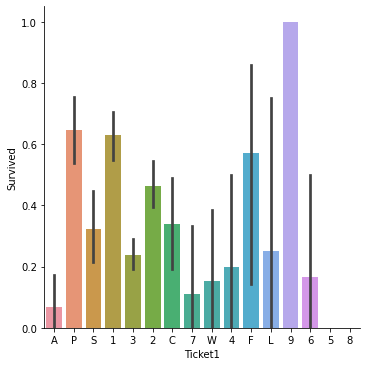

In [32]:
sns.catplot(x="Ticket1", y="Survived", kind="bar", data=train)

In [33]:
test['Ticket1']=test["Ticket"].str.get(0)

In [34]:
Ticket= ['5','8','A','7','W','6','4','L','3','S','C','2','F','1','P','9']
encoder_ticket = OrdinalEncoder(categories=[Ticket])
my_array_ticket=encoder_ticket.fit_transform(train[['Ticket1']]).reshape((891,1)).tolist()
my_array_ticket_test=encoder_ticket.fit_transform(test[['Ticket1']]).reshape((418,1)).tolist()

In [35]:
train[['Ticket1']]=my_array_ticket
test[['Ticket1']]=my_array_ticket_test

In [36]:
train=train.drop('Ticket',axis=1)
test=test.drop('Ticket',axis=1)
train=train.drop('Cabin',axis=1)
test=test.drop('Cabin',axis=1)

In [37]:
train=train.drop('Name',axis=1)
test=test.drop('Name',axis=1)

In [38]:
X=train.drop('Survived',axis=1)
y=train['Survived']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

Use XGBClassifier.

In [39]:
my_model = XGBClassifier(n_estimators=500).fit(X_train, y_train, 
                                               early_stopping_rounds=5, 
                                               eval_set=[(X_test, y_test)],
                                               verbose=False,
                                               eval_metric='logloss')
y_pred=my_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.8609865470852018

In [40]:
predicted_classes=my_model.predict(test)


my_submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predicted_classes})
my_submission.to_csv('submission.csv', index=False)